# Create visuals for reports
__version 1.2__ added urban/rural aspects & cleaned up code

__version 1.1__ automated some of the work

In [23]:
import pandas as pd
import numpy as np
import os
import shapefile
from datetime import datetime, timedelta
import operator
import math
import copy
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import NullLocator
from matplotlib.ticker import FuncFormatter
import matplotlib
%matplotlib notebook

# change font
matplotlib.rcParams['font.sans-serif'] = "Lato"
matplotlib.rcParams['font.weight'] = "light"
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['axes.labelweight'] = 'bold'

### arguments + functions
measures are from 
* https://docs.google.com/spreadsheets/d/1ndHgP53atJ5J-EtxgWcpSfYG8LdzHpUsnb6mWybErYg/edit?ts=5e6f893e#gid=0
* ACAPS dataset

In [31]:
#lon_min,lat_min,lon_max,lat_max
bbox = {'IND': ('India', 68.1, 7.90, 97.41, 35.5),
        'IDN': ('Indonesia', 95.29, -10.363, 141.1, 5.48),
        'MEX': ('Mexico', -117.2, 14.5, -86.6, 32.73),
        'NGA': ('Nigeria', 2.68, 4.24, 14.7, 13.88),
        'MYS': ('Malaysia', 100.0, 0.77, 119.8, 7),
        'COL': ('Colombia',-79.0, -4.3, -66.87, 12.44),
        'CIV': ("Cote d'Ivoire",-8.62,4.16,-2.5,10.75),
        'MMR': ("Myanmar",92.30, 9.9, 101.19, 28.34),
        'MOZ': ('Mozambique',30.16, -26.75, 40.78, -10.31),
        'UKR': ('Ukraine', 22.0, 44.36, 40.1, 52.4),
        'DEU': ('Germany',5.85,47.14,15.015,54.73)
}

def load_stuff(country):

    measures = {'MYS': [(datetime(2020,3,18),'lockdown')],
                'IDN':[(datetime(2020,3,16),'physical\ndistancing\nenacted'),
                       (datetime(2020,4,27),'ban on going\nhome for\nRamadan')],
                'IND':[#(datetime(2020,3,5),'public\ngatherings\nlimited'),
                       #(datetime(2020,3,14),'emergency\nprotocols\ninvoked'),
                       (datetime(2020,3,24),'lockdown')],
                'MEX':[#(datetime(2020,3,14),'public\nhealh\nmeasures'),
                        (datetime(2020,3,30),'lockdown')],
                'MEX':[(datetime(2020,3,14),'public\nhealh\nmeasures'),(datetime(2020,3,30),'lockdown')],
                'NGA':[#(datetime(2020,3,23),'schools\nclosed\n(Lagos)'),
                       (datetime(2020,3,30),'domestic\ntravel\nrestrictions')],
                'COL':[(datetime(2020,3,12),'health\nemergency\ndeclared')],
                'CIV':[(datetime(2020,3,24),'national\ncurfew')],
                'MMR':[(datetime(2020,3,13),'suspension of\npublic gatherings')],
                'MOZ':[(datetime(2020,3,23),'limit public\ngatherings')],
                'UKR':[(datetime(2020,3,15),'lockdown')],
               }
    
    # define paths
    #load_path = "/home/vsekara/mb_data/cuebiq/nCoV/geostats/%s/" % country
    load_path = "/home/vsekara/mb_data/cuebiq/nCoV/geostats/%s-test/" % country
    #load_path = "/home/vsekara/mb_data/cuebiq/nCoV/geostats/%s-test/" % country
    #fig_save_path = '/home/vsekara/mb_data/turingdata2/code/vsekara/plots/2019-nCoV/cuebiq/data-report/Jun01/%s_' % country
    
    return measures.get(country,[]),load_path

def moving_average(y_,window=7):
    return [np.mean(y_[max(0,i-window+1):i+1]) for i in range(len(y_))]

def calculate_relative_change(t,m):
    # establish baseline
    baseline = defaultdict(list)
    for t_,m_ in zip(t,m):
        if t_ < datetime(2020,3,1):
            baseline[t_.weekday()].append(m_)
    # take mean of baseline
    baseline = dict([(k,np.median(v)) for k,v in baseline.items()])
    # calculate relative difference
    return dict([(t_,m_/baseline[t_.weekday()]) for t_,m_ in zip(t,m) if t_ >= datetime(2020,3,1)])

__functions for loading data__

In [32]:
def load_data(load_path,t_day,t_end,admin):

    distance = []
    time_at_home = []

    while t_day <= t_end:
        day = t_day.strftime('%Y%m%d00')
    
        # check if file exists
        if os.path.exists(load_path + '%s.csv' % day):

            # load file
            dat = pd.read_csv(load_path + '%s.csv' % day)
            # clean data
            dat = dat[(~dat[admin].isna()) & (dat[admin] != '-1')]

            # handle data
            distance.append((t_day,np.median(dat['distance_travelled'])))
            time_at_home.append((t_day,np.median(dat['time_at_home']/3600)))

        t_day += timedelta(days=1)
    
    return distance, time_at_home

def load_urban_rural_data(load_path,t_day,t_end):

    distance = {1:[],0:[]} # urbal = 1, rural = 0, uninhabited or ocean = -1 (we discard these)
    time_at_home = {1:[],0:[]}

    while t_day <= t_end:
        day = t_day.strftime('%Y%m%d00')
    
        # check if file exists
        if os.path.exists(load_path + '%s.csv' % day):

            # load file
            dat = pd.read_csv(load_path + '%s.csv' % day)
            # clean data
            dat = dat[(~dat[admin].isna()) & (dat[admin] != '-1') & (dat['urban'] != -1)]

            # calculate stuff
            for urban_val in [0,1]:
                distance[urban_val].append((t_day,np.median(dat[dat['urban'] == urban_val]['distance_travelled'])))
                time_at_home[urban_val].append((t_day,np.median(dat[dat['urban'] == urban_val]['time_at_home']/3600)))

        t_day += timedelta(days=1)
    
    return distance, time_at_home


def load_poverty_data(load_path,country,t_day,t_end,focus=False):
    # this is a stupid way of doing it, but it was the fastest and easiest way I could think off before the report deadline
    # values are binned according to (left <= pov < right)
    bins = {'NGA':[(0,0.2),(0.2,0.5),(0.5,1.1)], # set accordingly to have approx 1/3 sized groups
            'IDN':[(0,5.),(5.,10.),(10.,101.)], # set accordingly to have approx 1/3 sized groups
            'COL':[(1,11),(11,25),(25,101)], # set accordingly to have approx 1/3 sized groups
            'CIV':[(0,6.5),(7,7.5),(8,10)], # values are opposite (because it's a wealth estimate 0: wealthy, 9 poor )
            'MOZ':[(0,6.5),(7,7.5),(8,10)], # set accordingly to have approx 1/3 sized groups
           } 
    
    # distance
    distance_poverty = defaultdict(list)
    time_at_home_poverty = defaultdict(list)

    while t_day <= t_end:
        day = t_day.strftime('%Y%m%d00')

        # check if file exists
        if os.path.exists(load_path + '%s.csv' % day):

            # load file
            dat = pd.read_csv(load_path + '%s.csv' % day)
            # clean data
            dat = dat[(~dat['admin1'].isna()) & (dat['admin1'] != '-1')]
            
            # should analysis only focus on one particular admin
            if focus != False:
                dat = dat[dat['admin1'] == focus]

            for p_low,p_high in bins[country]:
                diss_dat = dat[(dat['poverty'] >= p_low) & (dat['poverty'] < p_high)]

                # handle data
                distance_poverty[round(p_low,2)].append((t_day,np.median(diss_dat['distance_travelled'])))
                time_at_home_poverty[round(p_low,2)].append((t_day,np.median(diss_dat['time_at_home']/3600)))

        t_day += timedelta(days=1)
            
    return distance_poverty, time_at_home_poverty

def load_admin_shapefiles(country):
    # load shapfiles
    path = '/home/vsekara/mb_data/magicbox-public/shapefiles/%s/gadm36_%s_1' % (country,country)
    sf = shapefile.Reader(path)
    shapes = sf.shapes()
    records = sf.records()
    fields = sf.fields[1:]

    # create admin to name mapping
    admin_to_name = dict([(r[2],r[3]) for r in records])
    
    return shapes,records,admin_to_name

__functions for plotting stuff - absolute/relative__ using february as refrence (if relative=True)

In [33]:
def plot_curves(X,plot,relative=True):
    plt.figure(figsize=(6,4))
    ax = plt.subplot(111)

    # unpack list of tuples
    t,m = zip(*X)
    
    if plot == 'distance':
        if relative:
            ylabel = 'change in travel distance'
            y_min = -1.02; y_max = 0.14
        else:
            ylabel = 'travel distance [km]'
            y_min = 0; y_max = 50

    if plot == 'time_home':
        if relative:
            ylabel = 'change in time spent at home'
            if country == 'MEX':
                y_min = -0.06; y_max = 2.29 # mexico
            else:
                y_min = -0.06; y_max = 0.34 # other countries
        else:
            ylabel = 'time spent at home [hours]'
            y_min = 4; y_max = 24
    
    if relative:
        t,m = zip(*sorted(calculate_relative_change(t,m).items()))
        # calculate change with repect to normal
        m = np.array(m)-1

    # add measures to plot
    for t_,r in measures:
        plt.axvline(x=t_,lw=1.1,color='red',ls='--')
        plt.text(t_,y_max,r,ha='center',va='bottom',weight='bold')

    plt.plot(t,m,'.',color='#0068ea',zorder=2,ms=4,alpha=.5)
    mm = moving_average(m,window)
    plt.plot(t,mm,color='#0068ea',lw=2,label='{} day average'.format(window))
    
    if relative:
        # mark "normal" (100%)
        plt.axhline(y=0,color='#282828',ls='-',lw=1.1)
        
        # add last value as text
        if mm[-1] > 0:
            plt.text(t[-1],mm[-1]+0.05,'+%.0f%%' % (mm[-1]*100),ha='center',va='bottom',weight='bold',fontsize=14)
        else:
            plt.text(t[-1],mm[-1]+0.05,'%.0f%%' % (mm[-1]*100),ha='center',va='bottom',weight='bold',fontsize=14)

    t_ = [datetime(2020,3,2) + timedelta(days = 7*w) for w in range(100) if ((datetime(2020,3,2)+timedelta(days = 7*w))-t_end).days < 3][::2]
    plt.xticks(t_,[tt.strftime('%d.%m') for tt in t_])
    plt.grid(lw=0.5,alpha=0.8,zorder=1,color='#dcdcdc')
    plt.ylabel(ylabel,weight='bold')

    if relative:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    if plot == 'time_home':
        plt.legend(loc=2,frameon=True)
    else:
        plt.legend(loc=1,frameon=True)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xlim(datetime(2020,1,31,12),t_end+timedelta(days=1))
    plt.ylim(y_min,y_max)

    plt.tight_layout()
    plt.show()
#     if relative:
#         plt.savefig(fig_save_path+"%s_relative.png" % plot,dpi=300,bbox_inches=0,pad=0)
#     else:
#         plt.savefig(fig_save_path+"%s_absolute.png" % plot,dpi=300,bbox_inches=0,pad=0)
#     plt.close()

plotting for COL


<IPython.core.display.Javascript object>


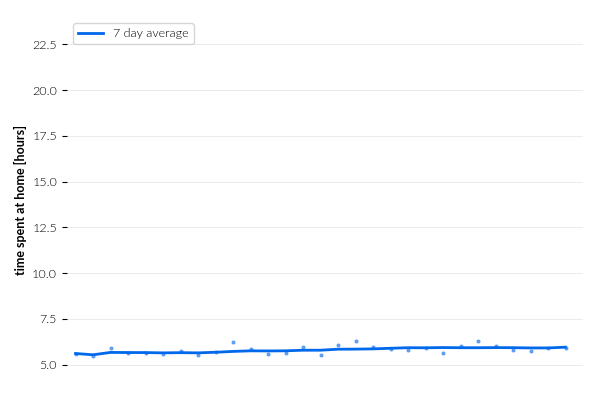

<IPython.core.display.Javascript object>


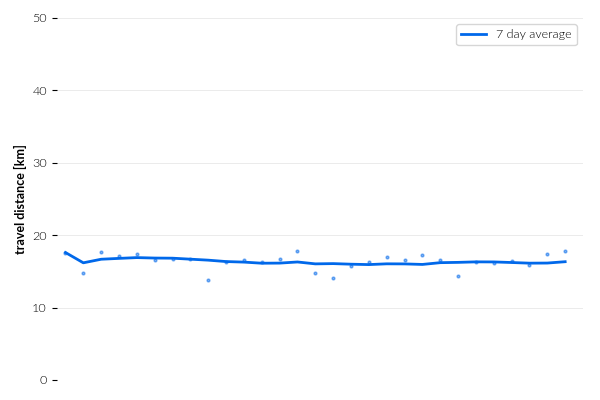

In [34]:
# start and end dates for plotting
t_start = datetime(2020,2,1); t_day = t_start
t_end = datetime(2020,2,29)

window = 7

countries = ['COL']

for country in countries:
    
    print('plotting for {}'.format(country))
    # load measures, data, and paths
    measures, load_path = load_stuff(country)
    measures = []
    # load data
    distance, time_at_home = load_data(load_path,t_start,t_end,'admin2')
    #distance_urban_rural, time_at_home_urban_rural = load_urban_rural_data(load_path,t_start,t_end)

    # plot stuff on country level
    #plot_curves(time_at_home,'time_home')
    plot_curves(time_at_home,'time_home',False)
    #plot_curves(distance,'distance')
    plot_curves(distance,'distance',False)
    
#     # disaggregate country level accoring tourban/rural indicator
#     plot_urban_rural_curves(time_at_home_urban_rural,'time_home',relative=True)
#     plot_urban_rural_curves(time_at_home_urban_rural,'time_home',relative=False)
#     plot_urban_rural_curves(distance_urban_rural,'distance',relative=True)
#     plot_urban_rural_curves(distance_urban_rural,'distance',relative=False)

#     # disaggregate country level according to poverty
#     if country in {'NGA','IDN','CIV','MOZ','COL'}:
#         distance_poverty, time_at_home_poverty = load_poverty_data(load_path,country,t_start,t_end)
#         plot_poverty_curves_absolute(distance_poverty,'distance')
#         plot_poverty_curves_absolute(time_at_home_poverty,'time_home')
#         plot_poverty_curves_relative(distance_poverty,'distance')
#         plot_poverty_curves_relative(time_at_home_poverty,'time_home')

__function for plotting curves for each admin1__

In [8]:
def plot_admin_curves(X,plot):
    admins = ['%s.%d_1' % (country,i) for i in range(1,len(X)+1)]
    colors = dict(zip(admins,plt.cm.rainbow(np.linspace(0,1,len(admins)))))
    
    if country in {'MYS','MMR','MOZ','CIV','DEU'}:
        sp_x = 4
        sp_y = 4
    elif country in {'IND','IDN','MEX','COL'}:
        sp_x = 6
        sp_y = 6
    elif country in {'UKR'}:
        sp_x = 6
        sp_y = 5
    elif country == 'NGA':
        sp_x = 7
        sp_y = 6
    offset = len(admins)-sp_x

    if plot == 'distance':
        absolute = X.copy()
        ylabel = 'change in travel distance'
        yticks = [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4]
        y_min = -1.02; y_max = 0.52

    if plot == 'time_home':
        absolute = X.copy()
        ylabel = 'change in time spent at home'
        yticks = [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4]
        y_min = -0.06; y_max = 0.39

    relative = dict()
    for admin in absolute:
        t,m = zip(*absolute[admin])
        try:
            base_dict = calculate_relative_change(t,m)
            relative[admin] = base_dict
        except:
            print('Admin %s has not enough data to establish a baseline' % admin)
            
    plt.figure(figsize=(3.9*sp_x,2.5*sp_y))
    p_count = 0
    for admin in admins:

        p_count += 1
        ax = plt.subplot(sp_y,sp_x,p_count)
        if admin in relative:
            t,m = zip(*sorted(relative[admin].items()))
            # calculate change with repect to normal
            m = np.array(m)-1
            
            plt.plot(t,m,'.',color=colors[admin],zorder=2,ms=4,alpha=.5)
            mm = moving_average(m,window)
            plt.plot(t,mm,color=colors[admin],lw=2,label=admin_to_name[admin])

            # add last value as text
            if 0 < mm[-1] < 0.3:
                plt.text(t[-1],mm[-1]+0.05,'+%.0f%%' % (mm[-1]*100),ha='center',va='bottom',weight='bold')
            elif mm[-1] <= 0:
                plt.text(t[-1],mm[-1]+0.05,'%.0f%%' % (mm[-1]*100),ha='center',va='bottom',weight='bold')
                
        # mark "normal" (100%)
        plt.axhline(y=0,color='#282828',ls='-',lw=1.1,zorder=2)

        # add measures to plot
        for t_,r_ in measures:
            plt.axvline(x=t_,lw=1.1,color='red',ls='--',zorder=2)
            if p_count <= sp_x:
                plt.text(t_,y_max,r_,ha='center',va='bottom',weight='bold')

        t_ = [datetime(2020,3,2) + timedelta(days = 7*w) for w in range(100) if ((datetime(2020,3,2)+timedelta(days = 7*w))-t_end).days < 3]
        t_ = t_[::4]
        plt.grid(lw=0.5,alpha=0.8,zorder=1,color='#dcdcdc')
        plt.legend(loc=1,frameon=True)

        # handle y-ticks
        if p_count % sp_x == 1:
            plt.yticks(yticks,yticks)
            plt.ylabel(ylabel,weight='bold')
            # force y-axis to be shown in percentages
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        else:
            plt.yticks(yticks,[])

        # handle x-ticks
        if p_count > offset:
            plt.xticks(t_,[tt.strftime('%d.%m') for tt in t_],fontsize=10)
            pass
        else:
            plt.xticks(t_,[])

        plt.xlim(datetime(2020,2,29,12),t_end+timedelta(days=1))
        plt.ylim(y_min,y_max)

        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.savefig(fig_save_path+'admins_'+"%s.png" % plot,dpi=300,bbox_inches=0,pad=0)
    plt.close()
    #plt.show()

__function to plot map of admins__

In [9]:
def plot_map_of_admins(X,t_day,plot):
    # load cuebiq users per 10k population 
    xpath = '/home/vsekara/mb_data/turingdata2/code/vsekara/small_data/epidemics/POIs-for-Cuebiq/users-per-10k/%s.csv'
    users_per_10k = pd.read_csv(xpath % country)
    ok_admins = set(users_per_10k[users_per_10k['cuebiq_users_per_10k'] > 2]['admin1'])

    if plot == 'time_home':
        ylabel = 'change in time spent at home'
    elif plot == 'distance':
        ylabel = 'change in travel distance'
    
    # calculate relative
    relative = dict()
    for admin in X:
        t,m = zip(*X[admin])
        try:
            base_dict = calculate_relative_change(t,m)
            relative[admin] = base_dict
        except:
            print('Admin %s has not enough data to establish a baseline' % admin)

    day = t_day.strftime('%Y%m%d00')

    # load bbox 
    _,lon_min,lat_min,lon_max,lat_max = bbox[country]

    # size figure
    alpha = (lat_max-lat_min)/(lon_max-lon_min)
    if alpha >= 1:
        fig = plt.figure(figsize=(5,5*alpha))
    else:
        fig = plt.figure(figsize=(5/alpha,5))
    ax = plt.subplot(111)

    # define colors
    bins = np.arange(20,181,1)
    colors = dict(zip(bins,plt.cm.PuOr_r(np.linspace(0,1,len(bins)))))

    # draw admins
    for s,r in zip(shapes,records):
        p = copy.copy(s.parts)
        p.append(len(s.points))
        x,y = zip(*s.points)
        for i,j in zip(p[:-1],p[1:]):
            lines = LineCollection([np.array([x[i:j],y[i:j]]).T],antialiaseds=(1,))

            # plot change in measure
            if r[2] in ok_admins and t_day in relative[r[2]]:
                # hacky way of calculating average over last 4 days
                value = int(round(0.25*(relative[r[2]][t_day]*100 + 
                                  relative[r[2]][t_day - timedelta(days = 1)]*100 + 
                                  relative[r[2]][t_day - timedelta(days = 2)]*100 + 
                                  relative[r[2]][t_day - timedelta(days = 3)]*100),0))
                if value < 20:
                    value = 20
                if value > 180:
                    value = 180
                lines.set_facecolors(colors[value])
            else:
                lines.set_facecolors('#dcdcdc')

            #lines.set_edgecolors('#282828')
            lines.set_edgecolors('white')
            lines.set_linewidth(0.5)
            lines.set_zorder(1)
            ax.add_collection(lines)

    plt.axis('off')
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    plt.xlim(lon_min,lon_max)
    plt.ylim(lat_min,lat_max)
    #plt.tight_layout()          

#     if country == 'IDN':
#         cax = fig.add_axes([0.3, 0.92, 0.25, 0.04]) # [left, bottom, width, height] 
#     elif country == 'NGA':
#         cax = fig.add_axes([0.4, 0.08, 0.45, 0.04]) # [left, bottom, width, height] 
#     else:
#         cax = fig.add_axes([0.3, 0.8, 0.25, 0.04]) # [left, bottom, width, height] 
#     mapper_ = plt.cm.ScalarMappable(cmap='PuOr_r')
#     mapper_.set_array(bins)
#     cbar = plt.colorbar(mapper_,orientation='horizontal', cax = cax, ticks=[20,40,60,80,100,120,140,160,180])
#     cbar.ax.set_xticklabels(['20%','40%','60%','80%','100%','120%','140%','160%','180%'],fontsize=10)  # horizontal colorbar
#     cbar.set_label(ylabel,fontsize=12,weight='bold')

    #plt.show()
    plt.savefig(fig_save_path + 'change-%s.png' % day,dpi=300,bbox_inches=0,pad=0)
    plt.close()

# <font color='purple'> Disaggregate mobility along urban / rural dimension </font>

In [10]:
def plot_urban_rural_curves(X,plot,relative=True):
    colors = {1:'#0068ea',0:'orange'}
    labels = {1:'Urban',0:'Rural'}
        
    if plot == 'distance':
        if relative:
            ylabel = 'change in travel distance'
            y_min = -1.02#; y_max = 0.14
        else:
            ylabel = 'travel distance [km]'
            #y_min = 0; y_max = 50

    if plot == 'time_home':
        if relative:
            ylabel = 'change in time spent at home'
            if country == 'MEX':
                y_min = -0.06#; y_max = 2.59 # mexico
            else:
                y_min = -0.06#; y_max = 0.34 # other countries
        else:
            ylabel = 'time spent at home [hours]'
            #y_min = 7.5; y_max = 18.5
    

    plt.figure(figsize=(6,4))
    ax = plt.subplot(111)

    max_text = 0 # find out where to position text
        
    for k in X:
        t,m = zip(*X[k])
    
        if relative:
            # normalize
            t,m = zip(*sorted(calculate_relative_change(t,m).items()))
            # calculate change with repect to normal
            m = np.array(m)-1

        # plot stuff
        plt.plot(t,m,'.',color=colors[k],zorder=2,ms=4,alpha=.5)
        mm = moving_average(m,window)
        #plt.plot(t,mm,color=colors[k],lw=2,label='{} ({} day average)'.format(labels[k],window))
        plt.plot(t,mm,color=colors[k],lw=2,label='{}'.format(labels[k]))
        max_text = max(max_text,max(m))
    
        if relative:
            # add last value as text
            if mm[-1] > 1:
                plt.text(t[-1],mm[-1]+0.05,'+%.0f%%' % (mm[-1]*100),ha='center',va='bottom',weight='bold',fontsize=14)
            else:
                plt.text(t[-1],mm[-1]+0.05,'%.0f%%' % (mm[-1]*100),ha='center',va='bottom',weight='bold',fontsize=14)
 
        # add measures to plot    
    for t_,r in measures:
        plt.axvline(x=t_,lw=1.1,color='red',ls='--')
        plt.text(t_,max_text*1.05,r,ha='center',va='bottom',weight='bold')        
        
    if relative:
        # mark "normal" (100%)
        plt.axhline(y=0,color='#282828',ls='-',lw=1.1)   
        t_ = [datetime(2020,3,2) + timedelta(days = 7*w) for w in range(100) if ((datetime(2020,3,2)+timedelta(days = 7*w))-t_end).days < 3][::2]
    else:
        t_ = [datetime(2020,2,3) + timedelta(days = 7*w) for w in range(100) if ((datetime(2020,2,3)+timedelta(days = 7*w))-t_end).days < 3][::2]
    plt.xticks(t_,[tt.strftime('%d.%m') for tt in t_])
    plt.grid(lw=0.5,alpha=0.8,zorder=1,color='#dcdcdc')
    plt.ylabel(ylabel,weight='bold')

    if relative:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    if plot == 'time_home':
        plt.legend(loc=0,frameon=True)
    else:
        plt.legend(loc=0,frameon=True)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    if relative:
        plt.xlim(datetime(2020,2,29,12),t_end+timedelta(days=1))
        #plt.ylim(y_min,y_max)
        plt.ylim(y_min,max_text)
    else:
        plt.xlim(datetime(2020,2,1,12),t_end+timedelta(days=1))
    
    plt.tight_layout()
    #plt.show()
    if relative:
        plt.savefig(fig_save_path+"%s_urban_relative.png" % plot,dpi=300,bbox_inches=0,pad=0)
    else:
        plt.savefig(fig_save_path+"%s_urban_absolute.png" % plot,dpi=300,bbox_inches=0,pad=0)
    plt.close()

# <font color='orange'> Disaggregate mobility along poverty dimension </font>
* NGA "poverty_home_area" field denotes the proportion of pople living in poverty ($2 / day or less)
* IDN "poverty" is from survey - unclear what definition it uses 

__function for plotting absolute changes__

In [16]:
def plot_poverty_curves_absolute(X,plot,extra=''):

    if plot == 'distance':
        ylabel = 'travel distance [km]'
        #y_min = -4; y_max = 20

    if plot == 'time_home':
        ylabel = 'time spent at home [hours]'
        #y_min = 9.5; y_max = 19.5
        
#     if country == 'NGA':
#         labels_map = {0:'richest', 0.2:'middle', 0.5:'poorest'}
#         colors = {0:'#0068ea',0.2:'orange',0.5:'red'}
#     elif country == 'IDN':
#         labels_map = {0:'richest', 5.:'middle', 10.:'poorest'}
#         colors = {0:'#0068ea',5.:'orange',10.:'red'}
        
    # if the estimates we have a for poverty
    if country in {'NGA','COL','IDN'}:
        labels_map = dict(zip(sorted(X.keys()),['richest','middle','poorest']))
        colors = dict(zip(sorted(X.keys()),['#0068ea','orange','red']))
    
    # if the estimates we have are for wealth
    elif country in {'CIV','MOZ'}:
        labels_map = dict(zip(sorted(X.keys(),reverse=True),['richest','middle','poorest']))
        colors = dict(zip(sorted(X.keys(),reverse=True),['#0068ea','orange','red']))

    plt.figure(figsize=(6,4))
    ax = plt.subplot(111)

    max_text = 0 # find out where to position text

    for poverty in X:

        t,m = zip(*X[poverty])   
        plt.plot(t,m,'.',color=colors[poverty],zorder=2,ms=4,alpha=.5)
        plt.plot(t,moving_average(m,window),label=labels_map[poverty],color=colors[poverty],lw=2)
        max_text = max(max_text,max(m))

    # mark "normal" (100%)
    #plt.axhline(y=0,color='#282828',ls='-',lw=1.1,zorder=2)

    # add measures to plot
    for t_,r in measures:
        plt.axvline(x=t_,lw=1.1,color='red',ls='--',zorder=2)
        plt.text(t_,max_text*1.05,r,ha='center',va='bottom',weight='bold')

    t_ = [datetime(2020,2,3) + timedelta(days = 7*w) for w in range(100) if ((datetime(2020,2,3)+timedelta(days = 7*w))-t_end).days < 3][::2]
    plt.xticks(t_,[tt.strftime('%d.%m') for tt in t_])
    plt.grid(lw=0.5,alpha=0.8,zorder=1,color='#dcdcdc')
    plt.ylabel(ylabel,weight='bold')

    plt.legend(loc=0,frameon=True)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xlim(datetime(2020,2,1,12),t_end+timedelta(days=1))
    #plt.ylim(y_min,y_max)

    #plt.show()
    if extra!='':
        plt.savefig(fig_save_path+"%s_%s_poverty_absolute.png" % (plot,extra),dpi=300,bbox_inches=0,pad=0)
    else:
        plt.savefig(fig_save_path+"%s_poverty_absolute.png" % plot,dpi=300,bbox_inches=0,pad=0)
    plt.close()

__relative changes__

In [12]:
def plot_poverty_curves_relative(X,plot,extra=''):

    if plot == 'distance':
        ylabel = 'change in travel distance'
        y_min = -1.02; y_max = 0.14

    if plot == 'time_home':
        ylabel = 'change in time spent at home'
        if country == 'MEX':
            y_min = 0.94; y_max = 1.99 # mexico
        else:
            y_min = -0.12; y_max = 0.49 # other countries

#     if country == 'NGA':
#         labels_map = {0:'richest', 0.2:'middle', 0.5:'poorest'}
#         colors = {0:'#0068ea',0.2:'orange',0.5:'red'}
#     elif country == 'IDN':
#         labels_map = {0:'richest', 5.:'middle', 10.:'poorest'}
#         colors = {0:'#0068ea',5.:'orange',10.:'red'}

    # if the estimates we have a for poverty
    if country in {'NGA','COL','IDN'}:
        labels_map = dict(zip(sorted(X.keys()),['richest','middle','poorest']))
        colors = dict(zip(sorted(X.keys()),['#0068ea','orange','red']))
    
    # if the estimates we have are for wealth
    elif country in {'CIV','MOZ'}:
        labels_map = dict(zip(sorted(X.keys(),reverse=True),['richest','middle','poorest']))
        colors = dict(zip(sorted(X.keys(),reverse=True),['#0068ea','orange','red']))

    plt.figure(figsize=(6,4))
    ax = plt.subplot(111)

    offset = 0
    for poverty in sorted(X):
    
        # unpack data
        t,m = zip(*X[poverty])

        # normalize
        t,m = zip(*sorted(calculate_relative_change(t,m).items()))
        # calculate change with repect to normal
        m = np.array(m)-1

        # plot stuff
        plt.plot(t,m,'.',color=colors[poverty],zorder=2,ms=4,alpha=.5)
        mm = moving_average(m,window)
        plt.plot(t,mm,label=labels_map[poverty],color=colors[poverty],lw=2)
        
        # add last value as text
        if mm[-1] > 0:
            plt.text(t[-1]+timedelta(days=offset),mm[-1],'+%.0f%%' % (mm[-1]*100),
                    ha='center',va='bottom',weight='bold',fontsize=14,color=colors[poverty])
        else:
            plt.text(t[-1]+timedelta(days=offset),mm[-1],'%.0f%%' % (mm[-1]*100),
                     ha='center',va='bottom',weight='bold',fontsize=14,color=colors[poverty])
        offset += 3

    # mark "normal" (100%)
    plt.axhline(y=0,color='#282828',ls='-',lw=1.1,zorder=2)

    # add measures to plot
    for t_,r in measures:
        plt.axvline(x=t_,lw=1.1,color='red',ls='--',zorder=2)
        plt.text(t_,y_max,r,ha='center',va='bottom',weight='bold')

    t_ = [datetime(2020,3,2) + timedelta(days = 7*w) for w in range(100) if ((datetime(2020,3,2)+timedelta(days = 7*w))-t_end).days < 3][::2]
    plt.xticks(t_,[tt.strftime('%d.%m') for tt in t_])
    plt.grid(lw=0.5,alpha=0.8,zorder=1,color='#dcdcdc')
    plt.ylabel(ylabel,weight='bold')

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    plt.legend(loc=0,frameon=True)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xlim(datetime(2020,2,29,12),t_end+timedelta(days=1))
    plt.ylim(y_min,y_max)
    #plt.show()
    if extra != '':
        plt.savefig(fig_save_path+"%s_%s_poverty_relative.png" % (plot,extra),dpi=300,bbox_inches=0,pad=0)
    else:
        plt.savefig(fig_save_path+"%s_poverty_relative.png" % plot,dpi=300,bbox_inches=0,pad=0)
    plt.close()

# plot all stuff

In [13]:
# # start and end dates for plotting
# t_start = datetime(2020,2,1); t_day = t_start
# t_end = datetime(datetime.now().year,datetime.now().month,datetime.now().day) - timedelta(days=1)

# window = 7

# countries = ['CIV','COL','IDN','IND','MEX','MMR','MOZ','MYS','NGA','UKR']

# for country in countries:
    
#     print('plotting for {}'.format(country))
#     # load measures, data, and paths
#     measures, load_path, fig_save_path = load_stuff(country)
#     # load data
#     distance, time_at_home = load_data(load_path,t_start,t_end)
#     distance_admins, time_at_home_admins = load_admin_data(load_path,t_start,t_end)
#     distance_urban_rural, time_at_home_urban_rural = load_urban_rural_data(load_path,t_start,t_end)
#     # load shapefiles
#     shapes,records,admin_to_name = load_admin_shapefiles(country)

#     # plot stuff on country level
#     plot_curves(time_at_home,'time_home')
#     plot_curves(time_at_home,'time_home',False)
#     plot_curves(distance,'distance')
#     plot_curves(distance,'distance',False)
    
#     # plot stuff on admin1 level
#     plot_admin_curves(distance_admins,'distance')
#     #plot_map_of_admins(distance_admins,t_end,'distance')
    
#     # disaggregate country level accoring tourban/rural indicator
#     plot_urban_rural_curves(time_at_home_urban_rural,'time_home',relative=True)
#     plot_urban_rural_curves(time_at_home_urban_rural,'time_home',relative=False)
#     plot_urban_rural_curves(distance_urban_rural,'distance',relative=True)
#     plot_urban_rural_curves(distance_urban_rural,'distance',relative=False)

#     # disaggregate country level according to poverty
#     if country in {'NGA','IDN','CIV','MOZ','COL'}:
#         distance_poverty, time_at_home_poverty = load_poverty_data(load_path,country,t_start,t_end)
#         plot_poverty_curves_absolute(distance_poverty,'distance')
#         plot_poverty_curves_absolute(time_at_home_poverty,'time_home')
#         plot_poverty_curves_relative(distance_poverty,'distance')
#         plot_poverty_curves_relative(time_at_home_poverty,'time_home')
        
# #         # focus on poverty analyis for specific regions & cities
# #         if country == 'NGA':
# #             distance_poverty, time_at_home_poverty = load_poverty_data(load_path,t_start,t_end,"NGA.25_1")
# #             plot_poverty_curves_absolute(distance_poverty,'distance','lagos')
# #             plot_poverty_curves_absolute(time_at_home_poverty,'time_home','lagos')
# #             plot_poverty_curves_relative`distance_poverty,'distance','lagos')
# #             plot_poverty_curves_relative(time_at_home_poverty,'time_home','lagos')